# Test Overlap between sources in a blend

In [1]:
# Import Packages and setup
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
from lsst.utils import getPackageDir
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

In [2]:
# Load the data
dataPath = os.path.abspath(os.path.join(lsst.utils.getPackageDir("testdata_deblender"), 'sim_data'))
filters = ["u", "g", "r", "i", "z", 'y']
imgFilename = os.path.join(dataPath, "test1/{0}_{1}.fits")
catFilename = os.path.join(dataPath, "test1/det_merge.fits")
simFilename = os.path.join(dataPath, "test1/catalog_true.fits")

expDb = proximal.ExposureDeblend(filters, imgFilename, catFilename, simFilename, useExactPeaks=True)
#pidx = 3
#condition = (expDb.mergedTable["peaks"]<=10) & (expDb.mergedTable["peaks"]>1)
pidx = 0
condition = (expDb.mergedTable["peaks"]<=5) & (expDb.mergedTable["peaks"]>1)
footprint, peaks = expDb.getParentFootprint(parentIdx=pidx, condition=condition, display=False)
deblend = proximal.DeblendedParent(expDb, footprint, peaks)

INFO:lsst.meas.deblender.proximal:Total parents: 9
INFO:lsst.meas.deblender.proximal:Unblended sources: 4
INFO:lsst.meas.deblender.proximal:Sources with multiple peaks: 5


INFO:lsst.meas.deblender:Sources not detected: 0



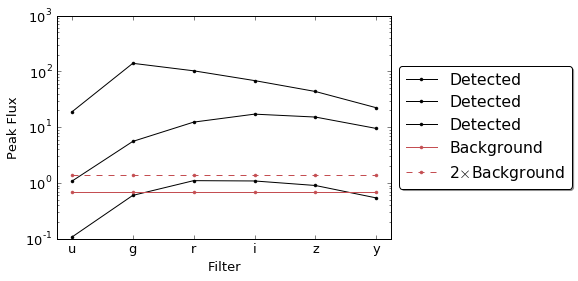

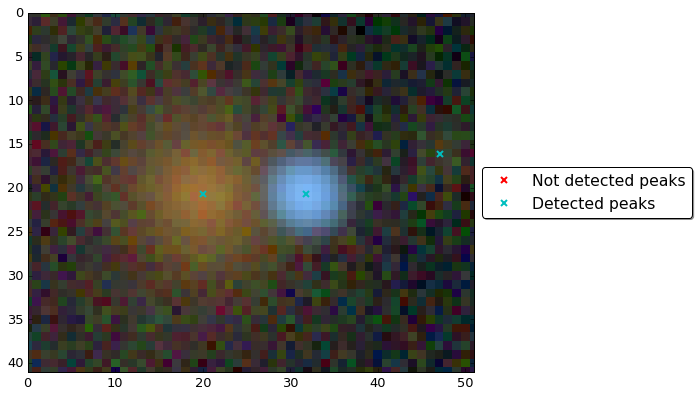

In [3]:
# Build a table of peaks detected by the pipeline
peakTable = sim.buildFootprintPeakTable(footprint, filters, peaks=peaks)
# Estimate the noise in the image
avgNoise = sim.getNoise(expDb.calexps)
simTable,idx, unmatchedTable = sim.matchFootprintToRef(footprint, peakTable, expDb.simTable,
                                                        filters,avgNoise=avgNoise, expDb=expDb,)
# Calculate the flux for isolated (non-blended) sources
sim.calculateIsolatedFlux(filters, expDb, peakTable, simTable, avgNoise)

In [4]:
%time dbr = sim.deblendFootprintOld(filters, expDb, footprint, peakTable)

CPU times: user 44.1 ms, sys: 2.48 ms, total: 46.6 ms
Wall time: 45.3 ms


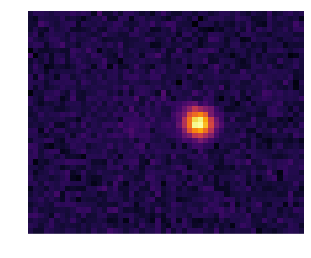

INFO:lsst.meas.deblender.proximal:constraints: MS


CPU times: user 3.5 s, sys: 78.7 ms, total: 3.58 s
Wall time: 3.58 s


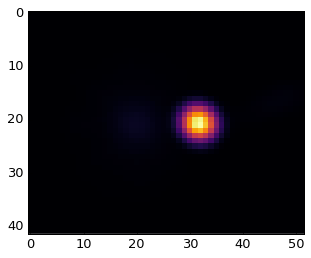

In [5]:
peakCoords = np.array([simTable["x"]+.5,simTable["y"]+.5]).T
#from astropy.table import vstack
#tbl = vstack([simTable, unmatchedTable])
#peakCoords = np.array([tbl["x"]+.5,tbl["y"]]).T
#%time glmm = expDb.deblendParent(condition=condition, parentIdx=pidx, display=True, maxiter=1000, constraints='MS', usePsf=False, psfThresh=3e-3, e_rel=1e-2, monotonicUseNearest=True, peaks=peakCoords, l0_thresh=.5)
%time glmm = expDb.deblendParent(condition=condition, parentIdx=pidx, display=False, maxiter=200, constraints='MS', usePsf=True, psfThresh=3e-3, e_rel=1e-2, monotonicUseNearest=True, peaks=peakCoords, l0_thresh=.1)

In [6]:
oldTemplates = sim.getODBTemplates(footprint, dbr, display=False)
simTemplates = sim.getSimTemplates(simTable, filters, footprint=footprint, display=False)
debTemplates = glmm.getAllTemplates()
debApportioned = glmm.getFluxPortionTemplates()

In [7]:
np.sum(debApportioned[1,0])

428.86607155949321

INFO:lsst.meas.deblender.display:Peak 0


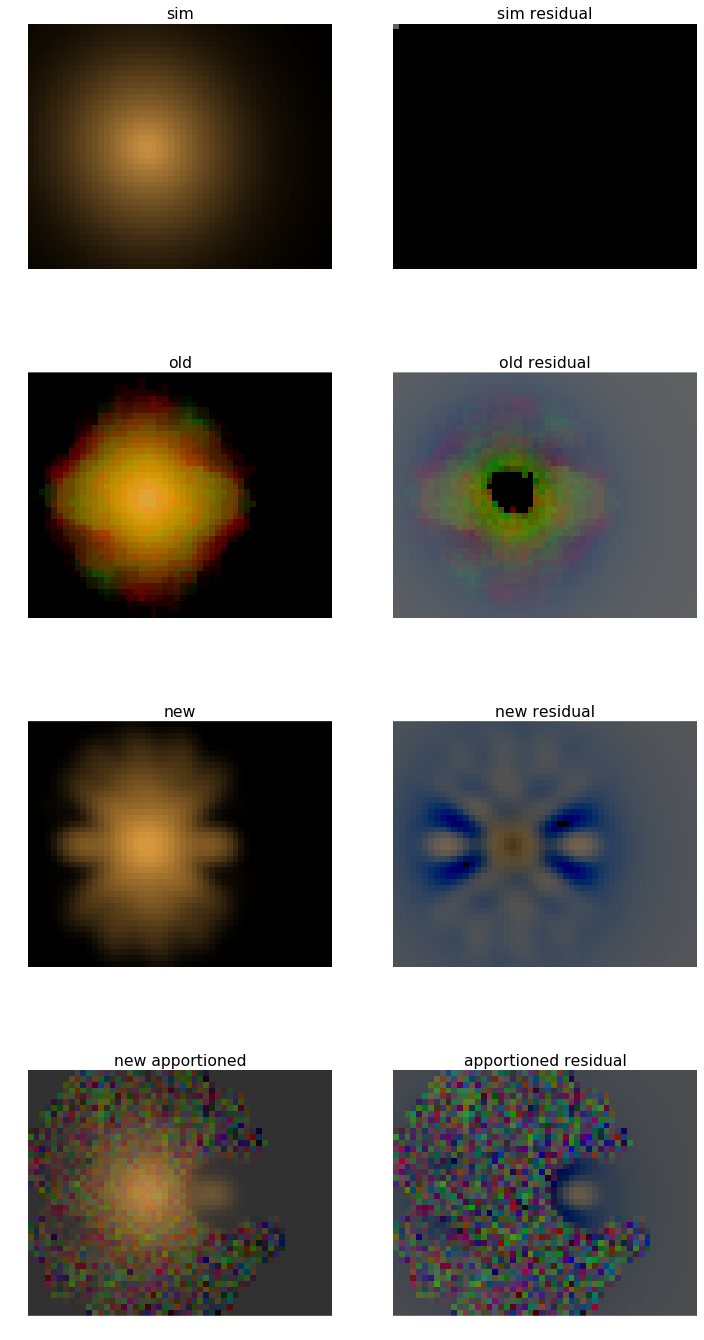

INFO:lsst.meas.deblender.display:Peak 1


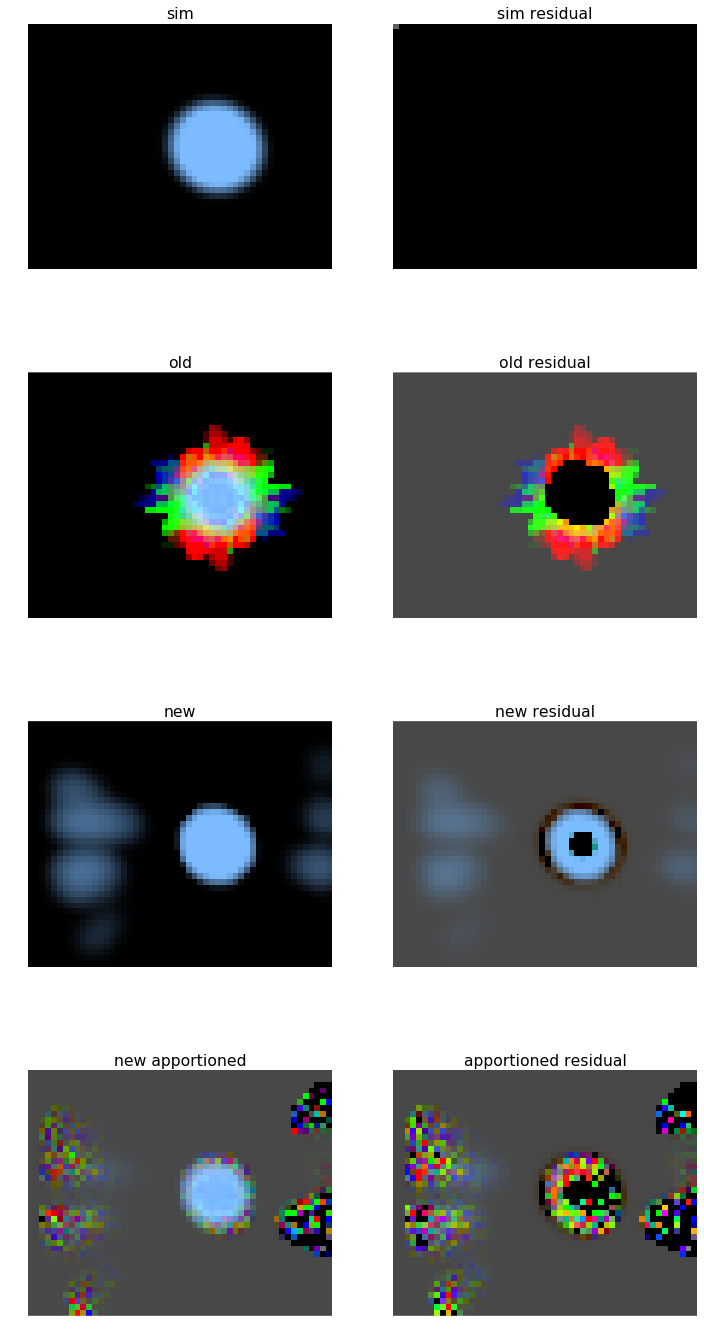

INFO:lsst.meas.deblender.display:Peak 2


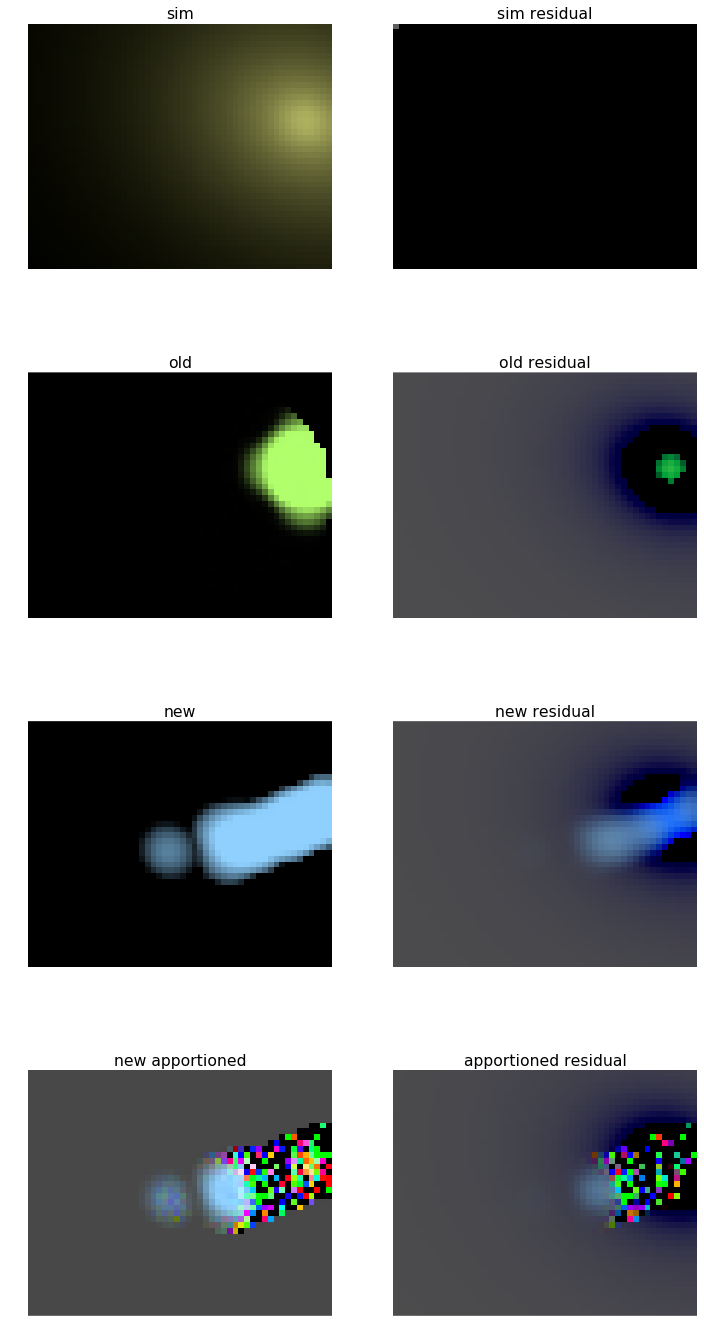

In [8]:
display.plotAllTemplates(OrderedDict([
    ("sim", simTemplates),
    ("sim residual", np.zeros_like(simTemplates)),
    ("old", oldTemplates),
    ("old residual", oldTemplates-simTemplates),
    ("new", debTemplates),
    ("new residual", debTemplates-simTemplates),
    ("new apportioned", debApportioned),
    ("apportioned residual", debApportioned-simTemplates)
]), columns=2)

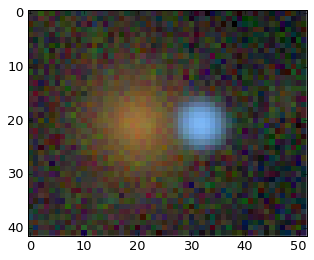

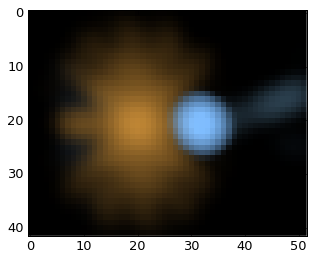

In [9]:
display.plotColorImage(np.array([calexp[footprint.getBBox()].getMaskedImage().getImage().getArray()
                                 for calexp in expDb.calexps]));
display.plotColorImage(glmm.model);

INFO:lsst.meas.deblender:Old Deblender Comparison


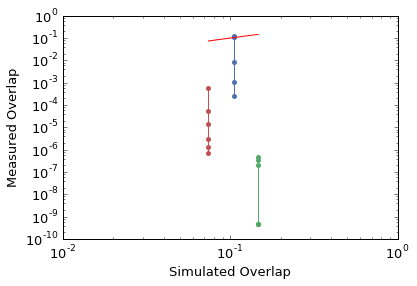

INFO:lsst.meas.deblender:NMF Deblender Comparison


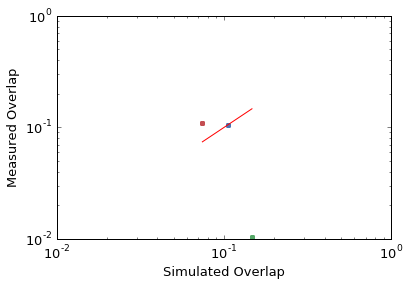

In [10]:
logger.info("Old Deblender Comparison")
ss, ds = sim.compareOverlap(simTemplates, oldTemplates, show=False)
logger.info("NMF Deblender Comparison")
ss, ds = sim.compareOverlap(simTemplates, debTemplates, show=False)

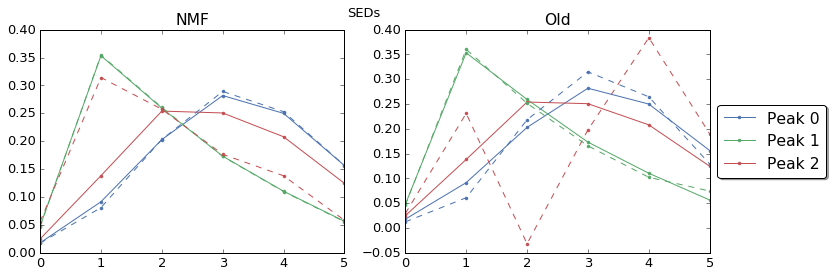

In [11]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
display.compareSeds([simTable, glmm.seds], filters, ax=ax1, show=False)
display.compareSeds([simTable, peakTable], filters, ax=ax2, show=False)
fig.suptitle("SEDs")
ax1.set_title("NMF")
ax2.set_title("Old")
plt.legend(loc="center left", fancybox=True, shadow=True, ncol=1, bbox_to_anchor=(1, 0.5))
plt.show()

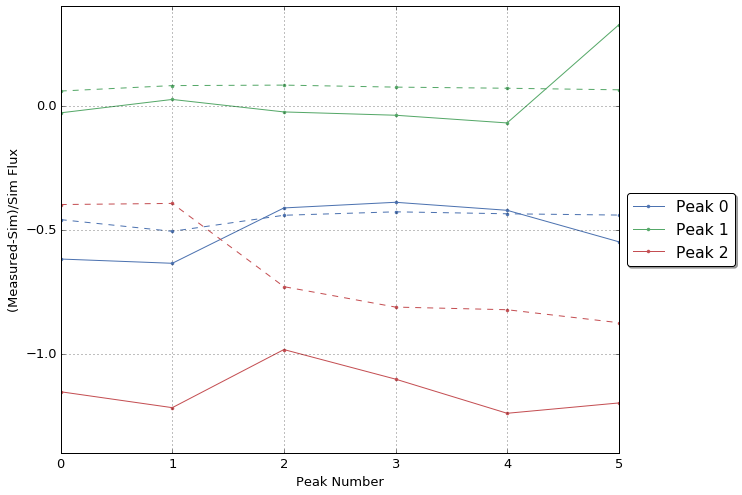

In [12]:
nmfPeakTable = peakTable.copy()
for pk, peak in enumerate(nmfPeakTable):
    for fidx, f in enumerate(expDb.filters):
        template = glmm.getTemplate(fidx, peak["peakIdx"])
        nmfPeakTable["flux_"+f][pk] = np.sum(template)

display.plotFluxDifference([peakTable, nmfPeakTable], simTable, filters, ax=None, show=True, color_cycle=None)